### 1. Import Library

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from sklearn.metrics import mean_squared_error

### 2. Import Data XRP

In [4]:
df = yf.Ticker("ETH-USD")
df = df.history(start="2020-01-01", end="2025-03-15")
del df["Dividends"]
del df["Stock Splits"]
forecastDF = df.copy()
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-10 00:00:00+00:00,2015.430420,2150.706299,1812.766846,1861.151367,35005066442
2025-03-11 00:00:00+00:00,1859.777710,1961.797729,1760.941772,1919.844971,30898385863
2025-03-12 00:00:00+00:00,1919.664795,1954.571167,1832.019043,1908.982666,22898872951
2025-03-13 00:00:00+00:00,1909.015381,1919.688232,1823.525391,1862.969604,17977225564
2025-03-14 00:00:00+00:00,1862.997925,1945.091431,1861.105957,1909.467529,12122715282


In [5]:
df.shape

(1900, 5)

In [19]:
xrp_dataset = df.to_csv('xrp_dataset.csv', index=False)

### 3. Close Price Visualization

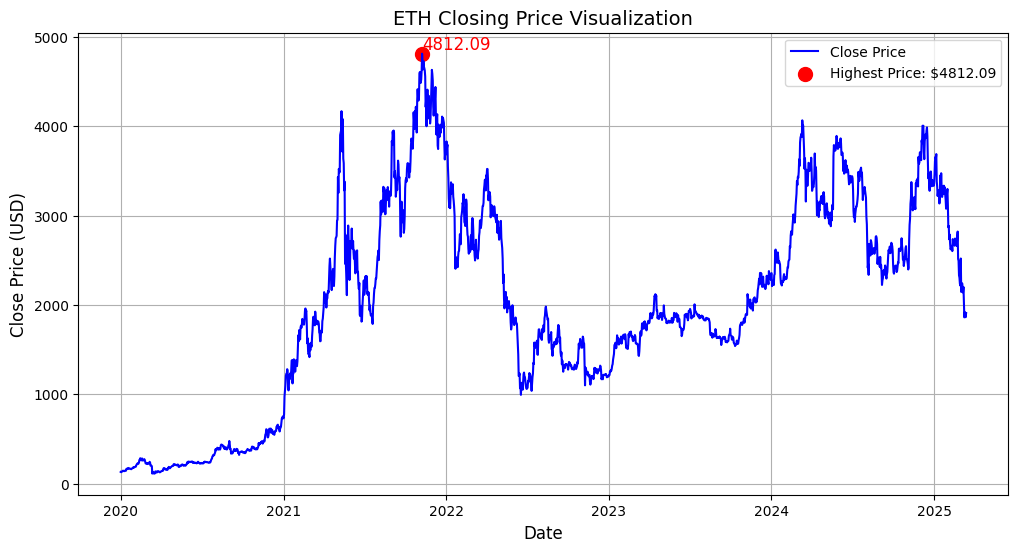

In [6]:
df = yf.Ticker("ETH-USD")
df = df.history(start="2020-01-01", end="2025-03-15")

df.drop(columns=["Dividends", "Stock Splits"], inplace=True)

forecastDF = df.copy()

max_price = df["Close"].max()
max_date = df[df["Close"] == max_price].index[0]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y="Close", label="Close Price", color="blue")

plt.scatter(max_date, max_price, color="red", marker="o", s=100, label=f'Highest Price: ${max_price:.2f}')
plt.text(max_date, max_price, f"{max_price:.2f}", color="red", fontsize=12, verticalalignment="bottom")

plt.title("ETH Closing Price Visualization", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price (USD)", fontsize=12)
plt.legend()
plt.grid()

plt.show()

### 4. Preprocessing

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df["Close"].values.reshape(-1, 1))
scaled_data

array([[0.00429569],
       [0.00357426],
       [0.00501243],
       ...,
       [0.38251278],
       [0.37272586],
       [0.38261591]])

In [8]:
def create_sequences(data, sequence_length):
  sequences = []
  labels = []
  for i in range(len(data) - sequence_length):
    sequences.append(data[i:i + sequence_length])
    labels.append(data[i + sequence_length, 0])
  return np.array(sequences), np.array(labels)

In [9]:
sequence_length = 30

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train =create_sequences(train_data, sequence_length)
X_test, y_test =create_sequences(test_data, sequence_length)

### Training Data (LSTM)

In [10]:
model = Sequential()

# 1 Layer
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# LSTM Layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=70, batch_size=84, validation_data=(X_test, y_test))

Epoch 1/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.1039 - val_loss: 0.0301
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0133 - val_loss: 0.0028
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 8/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 9/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 10/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 11/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 12/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

### 6. Model Evaluation

In [12]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
print(f"Mean Squared Error: {mse}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Mean Squared Error: 26055.412810437254


### 7. Prediction Price vs Actual Price

In [13]:
last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Etherium Price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted Etherium Price: 1878.5726318359375


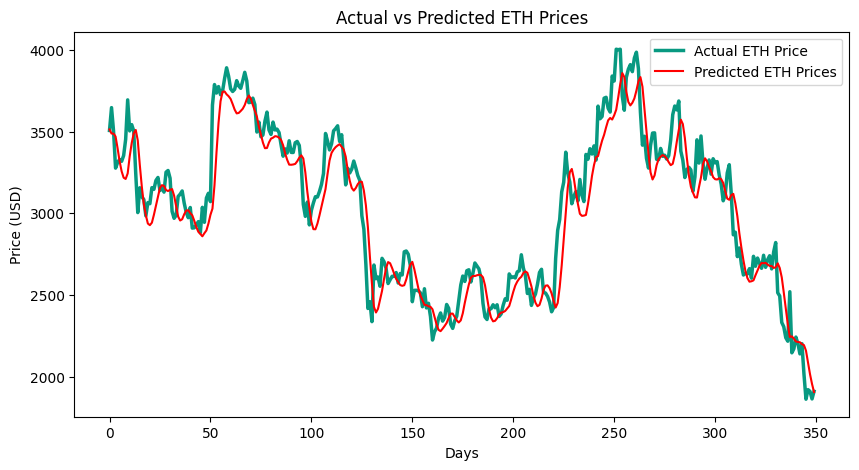

In [14]:
plt.figure(figsize=(10, 5))

plt.plot(y_test_scaled, label="Actual ETH Price", color='#089981', linewidth=2.5)
plt.plot(predictions, label='Predicted ETH Prices', color='red', linewidth=1.5)

plt.title('Actual vs Predicted ETH Prices')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()

plt.show()

### 8. Prediction Future Bitcoin Price 1 Month

In [15]:
future_days = 30

last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[1], X_predict.shape[0], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_30_days_scaled, predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data[-sequence_length:].reshape(-1, 1)

future_dates = pd.date_range(start=df.index[-1], periods=future_days+1, freq='D')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

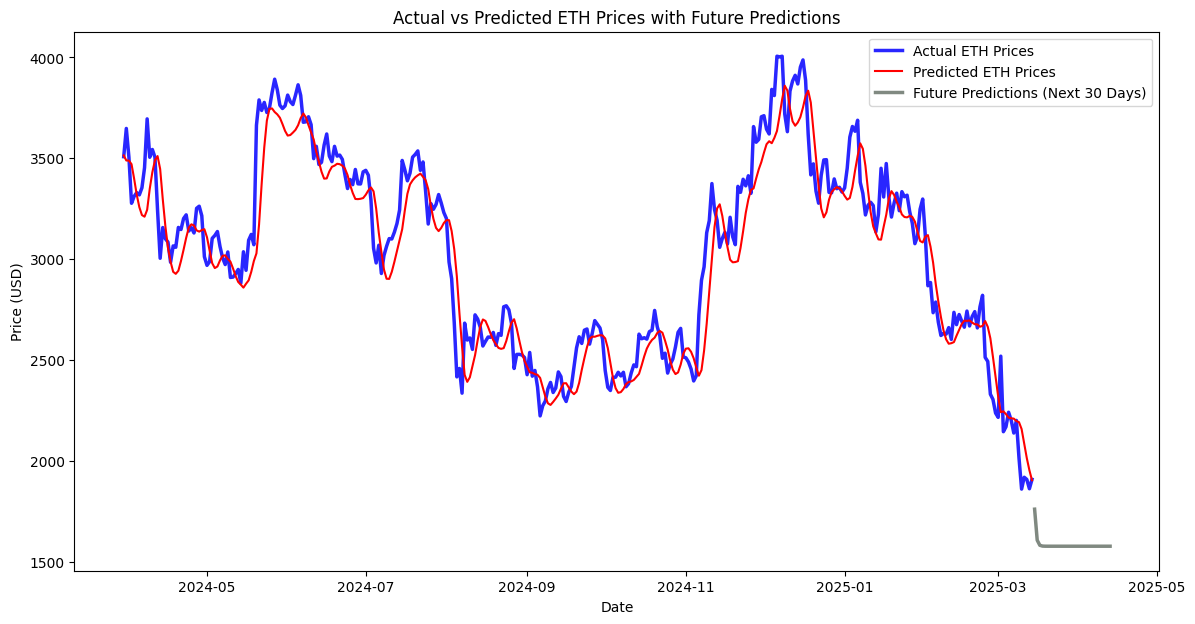

In [16]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label="Actual ETH Prices", color="#2926ff", linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label="Predicted ETH Prices", color="red", linewidth=1.5)
plt.plot(future_dates, future_predictions, label="Future Predictions (Next 30 Days)", color="#808981", linewidth=2.5)

plt.title("Actual vs Predicted ETH Prices with Future Predictions")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()

plt.show()

In [17]:
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions
})
future_predictions_df

,Date,Predicted Price
0,2025-03-15 00:00:00+00:00,1761.682007
1,2025-03-16 00:00:00+00:00,1607.981934
2,2025-03-17 00:00:00+00:00,1582.998901
3,2025-03-18 00:00:00+00:00,1578.961304
4,2025-03-19 00:00:00+00:00,1578.309326
5,2025-03-20 00:00:00+00:00,1578.204102
6,2025-03-21 00:00:00+00:00,1578.187134
7,2025-03-22 00:00:00+00:00,1578.184448
8,2025-03-23 00:00:00+00:00,1578.183960
9,2025-03-24 00:00:00+00:00,1578.183838


In [22]:
y_test_scaled_1d = y_test_scaled.flatten()
predictions_1d = predictions.flatten()

df_actual_vs_pred = pd.DataFrame({
    "Date": df.index[-len(y_test_scaled):],
    "Actual Price": y_test_scaled_1d,
    "Predicted Price": predictions_1d
})

df_future_pred = pd.DataFrame({
    "Date": future_dates,
    "Predicted Price": future_predictions
})

df_combined = pd.concat([df_actual_vs_pred, df_future_pred], ignore_index=True)

file_path = "ETH_Predictions.csv"
df_combined.to_csv(file_path, index=False)

print(f"File saved as: {file_path}")

File saved as: ETH_Predictions.csv


# 📊 Business Questions Based on ETH_Predictions.csv

## 1️⃣ Will Ethereum (ETH) experience a significant price drop in the next 30 days?

### 🔍 **Analysis:**
- Based on the predicted ETH price for the next 30 days, ETH is expected to follow a **downward trend** from **$1,761.68 (March 15, 2025) to around $1,578.18 (April 13, 2025)**.
- This indicates a **roughly 10% decline** in value over one month.

### 📌 **Conclusion:**
- Investors and traders should consider **risk mitigation strategies**, such as **hedging or selling part of their holdings** before the price drops further.
- Monitoring market trends and external factors (e.g., regulations, institutional investments) is also crucial.

---

## 2️⃣ How accurate is the model in predicting ETH prices compared to actual prices?

### 🔍 **Analysis:**
- By comparing **Actual Price** and **Predicted Price**, we can determine how closely the model aligns with reality.
- If the difference between **Actual Price** and **Predicted Price** is small, the model has **good accuracy**.
- However, if there is a **large discrepancy**, the model may need improvements, such as **parameter tuning, feature engineering, or additional training data**.

### 📌 **Conclusion:**
- If the model shows a **high error rate**, the next step is to **re-evaluate the features, fine-tune hyperparameters, or use more advanced models like LSTM**.
- If the model is **accurate**, it can serve as a valuable tool for investment strategies, helping traders anticipate market movements effectively.
